In [1]:
import numpy as np 
import pandas as pd
from mlp import mlp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import copy
import datetime


In [2]:
df = pd.read_csv("./dataset/BTC-USD.csv", )
Dates = pd.to_datetime(df.Date)
print df.head(), "\n", len(df)

         Date     Open     High      Low    Close  Adj Close  Volume
0  2010-07-16  0.04951  0.04951  0.04951  0.04951    0.04951       0
1  2010-07-17  0.04951  0.08585  0.05941  0.08584    0.08584       5
2  2010-07-18  0.08584  0.09307  0.07723  0.08080    0.08080      49
3  2010-07-19  0.08080  0.08181  0.07426  0.07474    0.07474      20
4  2010-07-20  0.07474  0.07921  0.06634  0.07921    0.07921      42 
2910


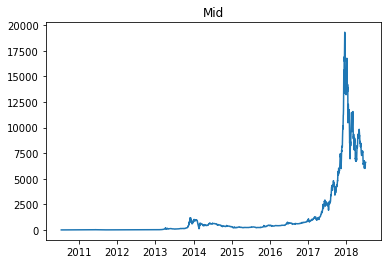

(2910,)


In [3]:
mid = ((df.High + df.Low)/2.)
plt.plot(Dates, mid)
plt.title("Mid")
plt.show()
print mid.shape

## Regressor

In [4]:
days = 8 # because the best one predicts today
span = 30

# return the time series till the day before to the day after
def series_creator(X, y=None, length=30, foresee_days=0):
    m = X.shape[0]
    X_n = []
    y_n = []
    for i in xrange(length, (m-foresee_days)):
        X_n.append(X[(i-length):i])
        if y is not None:
            y_n.append(y[i + foresee_days-1])
    
    if y is None:
        return np.vstack((X_n))
    else:
        return np.vstack((X_n)), np.hstack((y_n))
a = np.array([1,   2,  3,  4,  5,  6,  7,  8])
y = np.array([11, 12, 13, 14, 15, 16, 17, 18])
print series_creator(a, y, length=2, foresee_days=4)


(array([[1, 2],
       [2, 3]]), array([16, 17]))


In [5]:
X, y = series_creator(X=mid.values, y=mid, length=span, foresee_days=days) 
print X.shape, y.shape
scaler = MinMaxScaler() #just need to be defined here, aS THE Xs are equal
scaler.fit(X)
X_std = scaler.transform(X)

(2872, 30) (2872,)


In [6]:
X_train_std, X_a, y_train, y_a = train_test_split(X_std, y, test_size=0.30, random_state=42)


X_test_std, X_validation_std, y_test, y_validation = train_test_split(X_a, y_a, test_size=0.5, random_state=42)


print X_train_std.shape, X_validation_std.shape
print y_train.shape, y_validation.shape
generic_x = np.arange(len(y_test))

(2010, 30) (431, 30)
(2010,) (431,)


In [7]:
reg =  MLPRegressor(algorithm='adam', alpha=0.1, hidden_layer_sizes=(60), random_state=None,
                verbose=False, max_iter=10000, shuffle= False, tol=1e-10, early_stopping=False,
                   momentum=0.9)

In [8]:
def best_finder(ann, tot, mmin=0):
    ft = mmin
    for i in xrange(tot):
        ann.fit(X_train_std, y_train)
        mf = ann.score(X_validation_std, y_validation)
        #print i
        if mf>ft:
            print "better one found:", mf, i
            ft = mf
            my = copy.copy(ann)
    return my

In [9]:
reg = best_finder(reg, 3)
reg1 = copy.copy(reg)
print "final test", reg1.score(X_test_std, y_test)


better one found: 0.935113224809256 0
better one found: 0.9562609494449408 2
final test 0.9282576502579438


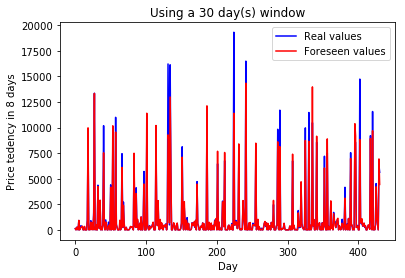

In [10]:
pred = reg1.predict(X_test_std)

plt.plot(y_test, c='b', label="Real values")
plt.plot(pred, c='r', label="Foreseen values")
plt.title("Using a %s day(s) window"%span)
plt.xlabel("Day")
plt.ylabel("Price tedency in %s days"%days)
plt.legend(loc='best')
plt.show()

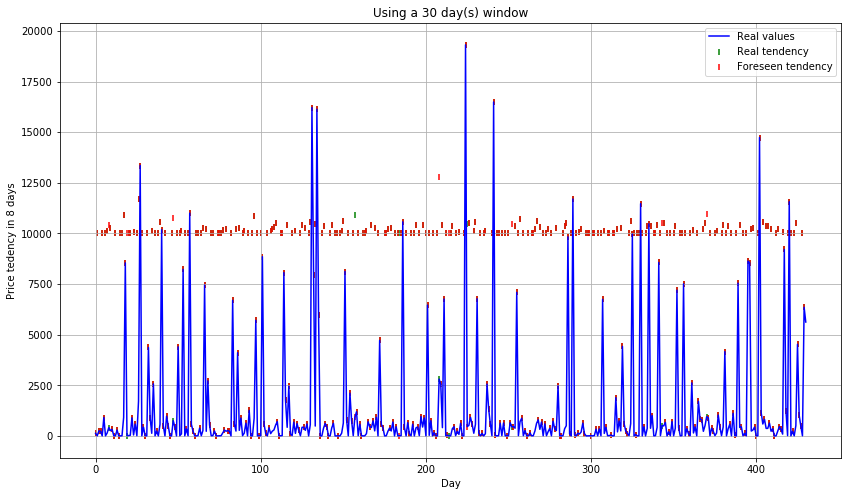

final ac: 92.83%


In [11]:
adj=10000
y_diff = y_test[1:] - y_test[:-1]
y_bin = np.where(1, y_diff>0, 0)
my = y_test[:-1] + adj*y_bin

pred_diff =  pred[1:] - pred[:-1]
pred_bin = np.where(1, pred_diff>0, 0)

my2 = y_test[:-1] + adj*pred_bin
plt.figure(figsize = (14,8))
plt.plot(y_test, c='b', label="Real values")


plt.scatter(generic_x[:-1], my, c='g',marker="|", label="Real tendency")
plt.scatter(generic_x[:-1], my2, c='r',marker="|", label="Foreseen tendency")
plt.grid()

plt.title("Using a %s day(s) window"%span)
plt.xlabel("Day")
plt.ylabel("Price tedency in %s days"%days)
plt.legend(loc='best')
plt.show()
print "final ac: %.2f%%"%(100*reg.score(X_test_std, y_test))

## Looking the trends (in %)

In [12]:
# return the time series till the day before to the day after, but in % to the previous
def series_creator_percent(X, y=None, length=30, foresee_days=0):
    m = X.shape[0]
    X_n = []
    y_n = []
    for i in xrange(length, (m-foresee_days)):
        X_n.append(X[(i-length):i])
        if y is not None:
            y_n.append(float(y[i + foresee_days-1])/y[i-1] - 1)
            #y_n.append(y[i-1])
    
    if y is None:
        return np.vstack((X_n))
    else:
        return np.vstack((X_n)), np.hstack((y_n))
a = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y = np.array([1, 2, 3, 4, 5, 6, 7, 8])
print series_creator_percent(a,y, length=1, foresee_days=1)

(array([[1],
       [2],
       [3],
       [4],
       [5],
       [6]]), array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
       0.16666667]))


In [13]:
X2, y2 = series_creator_percent(X=mid.values, y=mid, length=span, foresee_days=days) 
print X.shape, y.shape
X_std2 = scaler.transform(X2)



(2872, 30) (8,)


In [14]:
X_train_std2, X_a2, y_train2, y_a2 = train_test_split(X_std2, y2, test_size=0.30, random_state=42)


X_test_std2, X_validation_std2, y_test2, y_validation2 = train_test_split(X_a2, y_a2, test_size=0.5, random_state=42)



print X_train_std2.shape, X_validation_std2.shape, X_test_std2.shape
print y_train2.shape, y_validation2.shape, y_test2.shape


(2010, 30) (431, 30) (431, 30)
(2010,) (431,) (431,)


In [15]:
y_validation_bin = np.where(1, y_validation2>0, 0)
y_test_bin = np.where(1, y_test2>0, 0)
def bin_score(pred, y_bin):
    res = 0
    le = len(pred)
    pred_bin = np.where(1, pred>0, 0)
    for i in xrange(le):
        if y_bin[i]==pred_bin[i]:
            res +=1
    return float(res)/le


def best_finder_b(ann, tot, mmin=0):
    ft = mmin
    for i in xrange(tot):
        ann.fit(X_train_std2, y_train2)
        pred = ann.predict(X_validation_std2)
        mf = bin_score(pred, y_validation_bin)
        #print i
        if mf>ft:
            print "better one found:", mf, i
            ft = mf
            my = copy.copy(ann)
    return my

### Seeing tendencies in the binariazation of the regressor

In [16]:
#reg.fit(X_train_std, y_train)
reg = best_finder_b(reg, 100, 0.5)
reg2 = copy.copy(reg)
print reg2.score(X_test_std2, y_test2)
pred2 = reg2.predict(X_test_std2)
print "Accuracy for binarization", bin_score(pred2, y_test_bin)
pred_bin = np.where(1, pred2>0, 0)


better one found: 0.591647331787 0
better one found: 0.593967517401 1
better one found: 0.598607888631 2
better one found: 0.600928074246 3
better one found: 0.603248259861 55
0.008176657575122204
Accuracy for binarization 0.610208816705


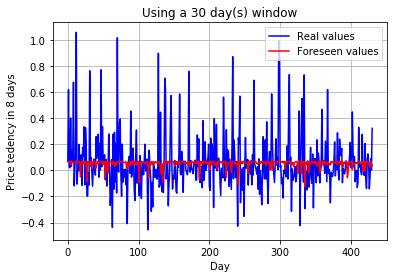

In [17]:
plt.plot(y_test2, c='b', label="Real values")
plt.plot(pred2, c='r', label="Foreseen values")

plt.xlabel("Day")
plt.grid()
plt.title("Using a %s day(s) window"%span)
plt.ylabel("Price tedency in %s days"%days)
plt.legend(loc='best')
plt.show()

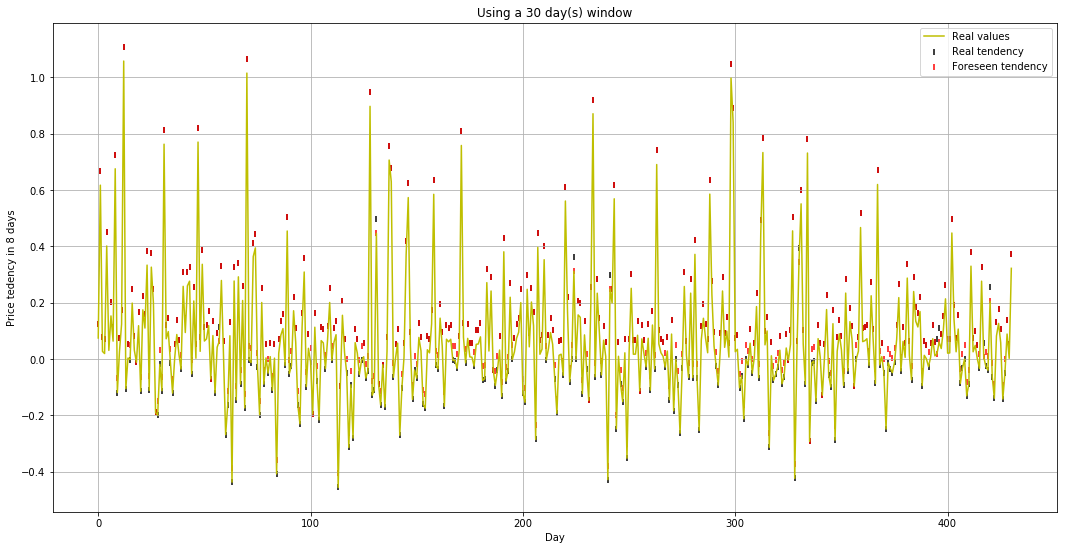

In [18]:

v = y_test2 + pred_bin/20.
v1 = y_test2 + y_test_bin/20.

plt.figure(figsize = (18,9))
plt.plot(generic_x, y_test2, c='y', label="Real values")
plt.scatter(generic_x, v1, c='k', marker="|", label="Real tendency")
plt.scatter(generic_x, v, c="r", marker="|", label="Foreseen tendency")


plt.xlabel("Day")
plt.grid()
plt.title("Using a %s day(s) window"%span)
plt.ylabel("Price tedency in %s days"%days)
plt.legend(loc='best')

plt.show()

## N days series


In [19]:
# return the time series till the day before to the day after
def series_creator_ndays(X, y=None, length=30, foresee_days=0):
    m = X.shape[0]
    X_n = []
    y_n = []
    for i in xrange(length, (m-foresee_days)):
        X_n.append(X[(i-length):i])
        if y is not None:
            y_n.append(y[i:i + foresee_days])
    
    if y is None:
        return np.vstack((X_n))
    else:
        return np.vstack((X_n)), np.vstack((y_n))
a = np.array([1,   2,  3,  4,  5,  6,  7,  8])
y = np.array([11, 12, 13, 14, 15, 16, 17, 18])
print series_creator_ndays(a, y, length=1, foresee_days=1)


(array([[1],
       [2],
       [3],
       [4],
       [5],
       [6]]), array([[12],
       [13],
       [14],
       [15],
       [16],
       [17]]))


In [20]:
X3, y3 = series_creator_ndays(X=mid.values, y=mid, length=span, foresee_days=days) 
print X3.shape, y3.shape
X_std3 = scaler.transform(X)

(2872, 30) (2872, 8)


In [21]:
X_train_std3, X_a3, y_train3, y_a3 = train_test_split(X_std3, y3, test_size=0.30, random_state=42)


X_test_std3, X_validation_std3, y_test3, y_validation3 = train_test_split(X_a3, y_a3, test_size=0.5, random_state=42)


print X_train_std3.shape, X_validation_std3.shape
print y_train3.shape, y_validation3.shape
generic_x = np.arange(len(y_test))

(2010, 30) (431, 30)
(2010, 8) (431, 8)


In [22]:
def best_finder(ann, tot, mmin=0):
    ft = mmin
    for i in xrange(tot):
        ann.fit(X_train_std3, y_train3)
        mf = ann.score(X_validation_std3, y_validation3)
        #print i
        if mf>ft:
            print "better one found:", mf, i
            ft = mf
            my = copy.copy(ann)
    return my

In [23]:
reg = best_finder(reg, 3)
reg3 = copy.copy(reg)
print "final test", reg3.score(X_test_std3, y_test3)

better one found: 0.9471862908478998 0
better one found: 0.961333934831016 1
final test 0.9401198169570641


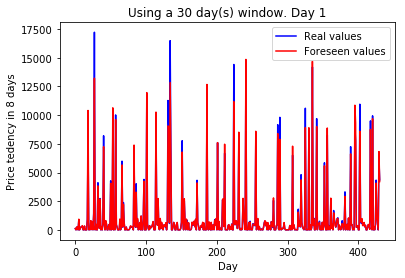

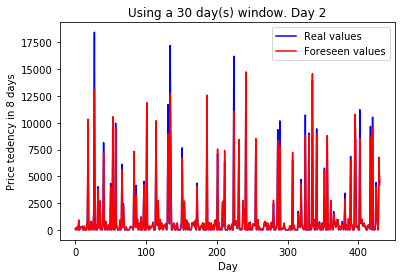

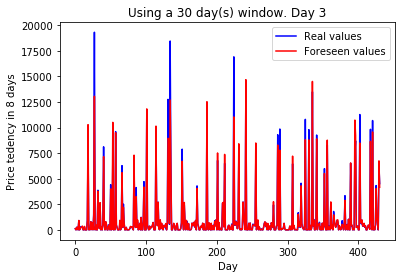

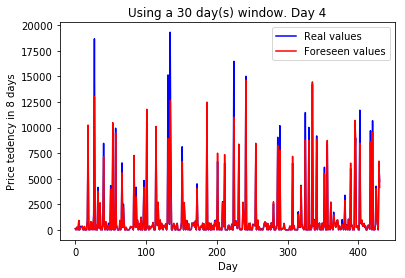

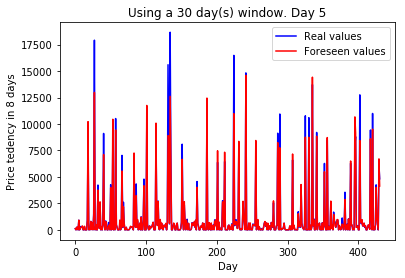

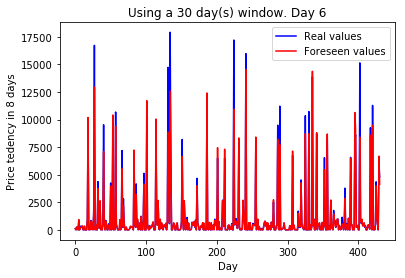

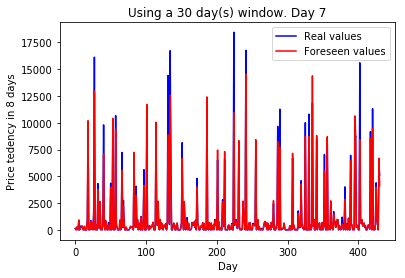

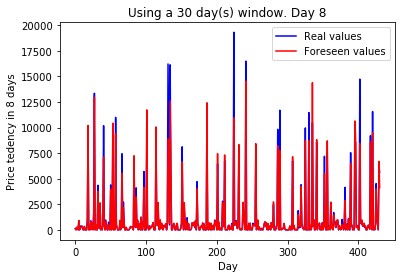

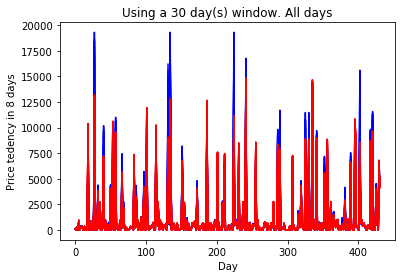

In [24]:
pred3 = reg3.predict(X_test_std3)

for i in xrange(days):
    plt.plot(y_test3[:,i], c='b', label="Real values")
    plt.plot(pred3[:, i], c='r', label="Foreseen values")
    plt.title("Using a %s day(s) window. Day %s"%(span, i+1))
    plt.xlabel("Day")
    plt.ylabel("Price tedency in %s days"%days)
    plt.legend(loc='best')
    plt.show()
    
plt.plot(y_test3, c='b')
plt.plot(pred3, c='r')
plt.title("Using a %s day(s) window. All days"%span)
plt.xlabel("Day")
plt.ylabel("Price tedency in %s days"%days)

plt.show()

day 1 ac: 96.99%
day 2 ac: 95.61%
day 3 ac: 94.52%
day 4 ac: 93.78%
day 5 ac: 93.77%
day 6 ac: 93.48%
day 7 ac: 92.71%
day 8 ac: 91.67%


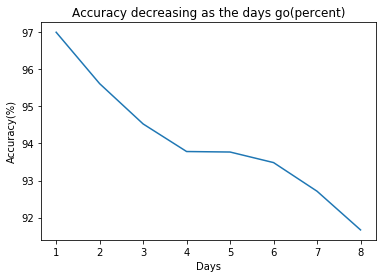

In [25]:
ac = []
xl = range(1, days+1)
for i in xrange(days):
    ac.append(100*r2_score(y_test3[:, i], pred3[:,i]))
    print "day %s ac: %.2f%%"%(i+1, ac[i] )
plt.plot(xl, ac)
plt.title("Accuracy decreasing as the days go(percent)")
plt.xlabel("Days")
plt.ylabel("Accuracy(%)")
plt.show()


## Testing my results

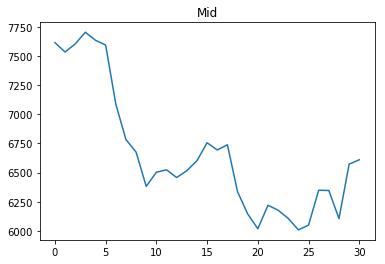

(1, 31)


In [26]:
mid_ = mid[-span-1:].values.reshape(1,-1)#, the -1 helps to see if its working, 
#it shortens the timespan, but if it's close to the real value of the baseline, it's a good sign
plt.plot(mid_[0,:])
plt.title("Mid")
plt.show()
print mid_.shape

In [27]:
Xf_std = scaler.transform(mid_[:, :-1])
print Xf_std.shape
ct = 26200/mid_[0,-1]#3.922 #brl cte corrected by the walltime Inc. price at the time, 13:00, 2018-07-05
print "Rate(usd to brl)", ct

(1, 30)
Rate(usd to brl) 3.9638623783846145


#### For n-days predictions (Best in accuracy)

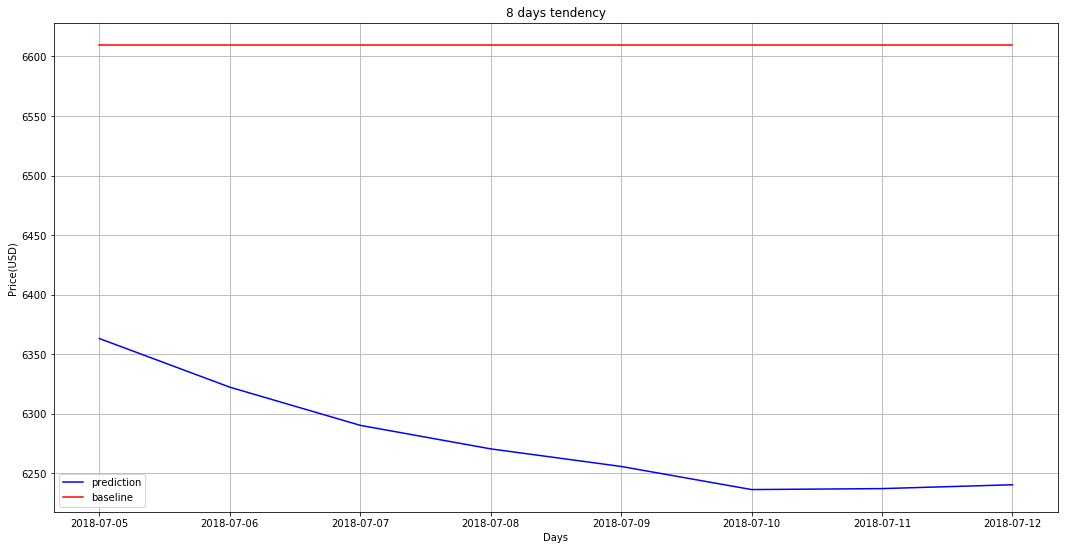

Prediction for 8 days from now: 6240.48
Delta from today to then: -369.23


In [41]:
final_prof = reg3.predict(Xf_std)
baseline = np.ones(final_prof.shape[1]) * mid_[0,-1]
datelist = pd.date_range(datetime.datetime.strptime(df.Date.values[-1], "%Y-%m-%d"), periods=days).values
#datelist = df.Date.values[-days:]
plt.figure(figsize = (18,9))
plt.plot(datelist, final_prof[0,:], c="b", label="prediction")
plt.plot(datelist, baseline, c="r", label="baseline")
plt.title("%s days tendency"%days)
plt.xlabel("Days")
plt.ylabel("Price(USD)")
plt.legend(loc="best")
plt.grid()
plt.show()
print "Prediction for %s days from now: %.2f"%(days, final_prof[0,-1])
print "Delta from today to then: %.2f"%(final_prof[0, -1] - mid_[0,-1])

In BRL


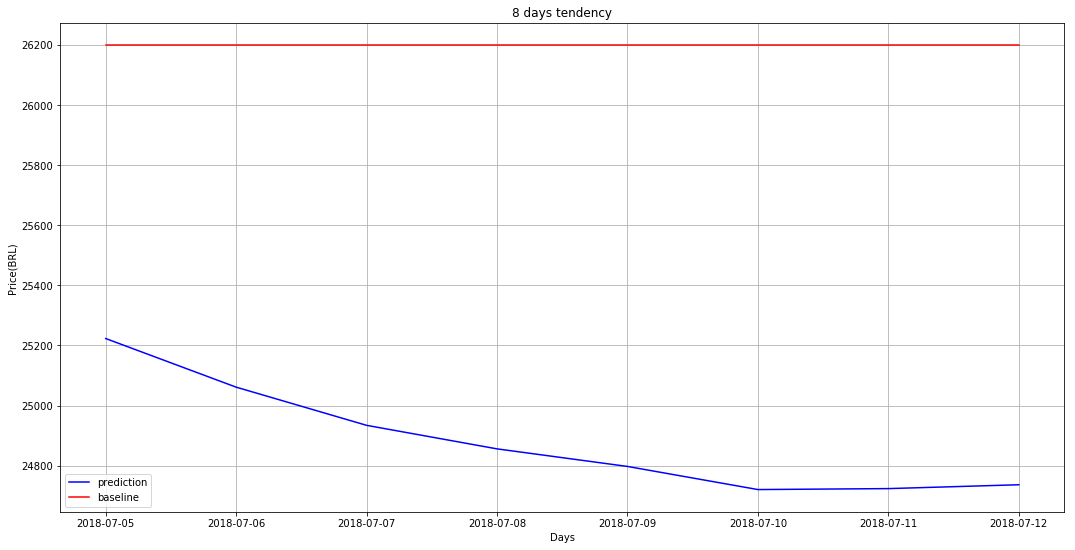

Prediction for 8 days from now: BRL 24736.41
Delta from today to then: BRL -1463.59


In [36]:
print "In BRL"
final_profb = final_prof * ct
baselineb = baseline * ct
plt.figure(figsize = (18,9))
plt.plot(datelist, final_profb[0,:], c="b", label="prediction")
plt.plot(datelist, baselineb, c="r", label="baseline")
plt.title("%s days tendency"%days)
plt.xlabel("Days")
plt.ylabel("Price(BRL)")
plt.legend(loc="best")
plt.grid()
plt.show()
print "Prediction for %s days from now: BRL %.2f"%(days, final_profb[0,-1])
print "Delta from today to then: BRL %.2f"%( final_profb[0, -1] - (mid_[0,-1]*ct) )


In [30]:
# Correcting the values to the tendency (Matching the predicted to the real to see the 'real' tendency only)


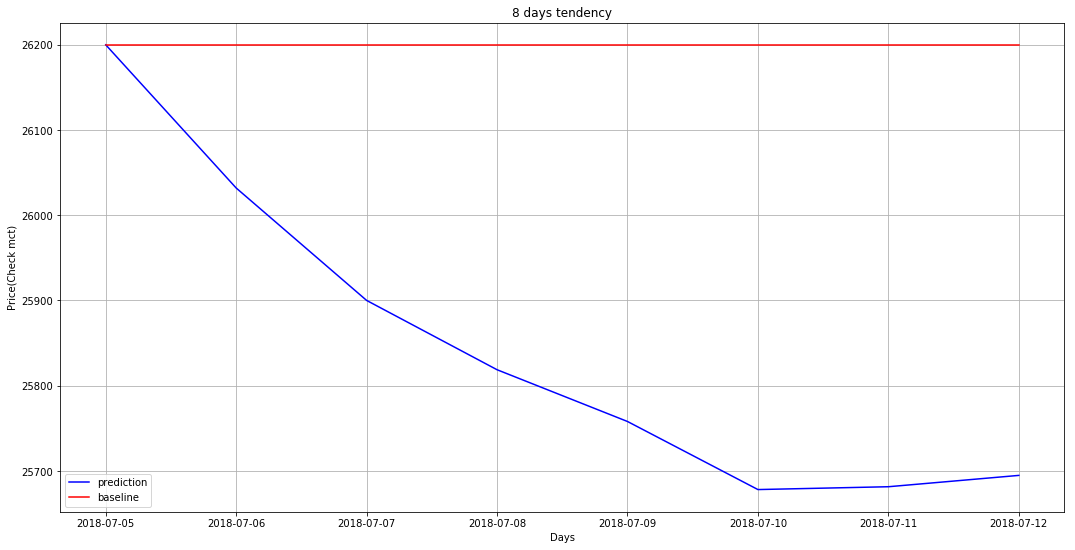

Corrected prediction for 8 days from now: 25694.74 (check mct)
Corrected delta from today to then: -505.26 (check mct)


In [47]:
mct = ct # change to 1 for no correction
rea_t_cte = mid_[0,-1]/final_prof[0,0]

plt.figure(figsize = (18,9))
plt.plot(datelist, final_prof[0,:]*rea_t_cte * mct , c="b", label="prediction")
plt.plot(datelist, baseline * mct, c="r", label="baseline")
plt.title("%s days tendency"%days)
plt.xlabel("Days")
plt.ylabel("Price(Check mct)")
plt.legend(loc="best")
plt.grid()
plt.show()
print "Corrected prediction for %s days from now: %.2f (check mct)"%(days, final_prof[0,-1]* rea_t_cte  * mct)
print "Corrected delta from today to then: %.2f (check mct)"%((final_prof[0, -1]*rea_t_cte - mid_[0,-1])*mct)


#### One day prediction (2nd best in accuracy)

In [34]:
print "Value today: USD %.2f"% mid_[0,-1]
print "Prediction for %s days from now (%s): USD %.2f"%(days, df.Date.values[-1], reg1.predict(Xf_std)[0])
print "Delta from today to then: USD %.2f"%(reg1.predict(Xf_std)[0] - mid_[0,-1] )


Value today: USD 6609.71
Prediction for 8 days from now (2018-07-05): USD 6501.46
Delta from today to then: USD -108.26


In [35]:
print "In BRL"
print "Value today: BRL %.2f"%(mid_[0,-1] *ct)
print "Prediction for %s days from now (%s): BRL %.2f"%(days, df.Date.values[-1], ct * reg1.predict(Xf_std)[0])
print "Delta from today to then: BRL %.2f"%((reg1.predict(Xf_std)[0] - mid_[0,-1]) * ct)


In BRL
Value today: BRL 26200.00
Prediction for 8 days from now (2018-07-05): BRL 25770.88
Delta from today to then: BRL -429.12


#### Percentage and binarization prediction (Worst in accuracy)

In [32]:
print "Value today (%s): USD %.2f"%(df.Date.values[-1], mid_[0,-1])
print "Percentage prediction: %.3f%%"%(reg2.predict(Xf_std)[0]*100)
print "Prediction for %s days from now: USD %.2f"%(days, (reg2.predict(Xf_std)[0] + 1 ) * mid_[0,-1])
print "Delta from today to then: USD %.2f"%(reg2.predict(Xf_std)[0]  * mid_[0, -1])

Value today (2018-07-05): USD 6609.71
Percentage prediction: 3.956%
Prediction for 8 days from now: USD 6871.20
Delta from today to then: USD 261.49


In [33]:
print "In BRL"
print "Value today (%s): BRL %.2f"%(df.Date.values[-1], mid_[0,-1] * ct)
print "Percentage prediction:  %.3f%%"%(reg2.predict(Xf_std)[0]*100)
print "Prediction for %s days from now: BRL %.2f"%(days, (reg2.predict(Xf_std)[0] + 1 ) *  mid_[0,-1] * ct )
print "Delta from today to then: BRL %.2f"%(reg2.predict(Xf_std)[0]  *  mid_[0,-1] * ct)


In BRL
Value today (2018-07-05): BRL 26200.00
Percentage prediction:  3.956%
Prediction for 8 days from now: BRL 27236.51
Delta from today to then: BRL 1036.51


In [42]:
rea_t_cte 

4.117429525913445